In [3]:
%load_ext autoreload
%autoreload 2

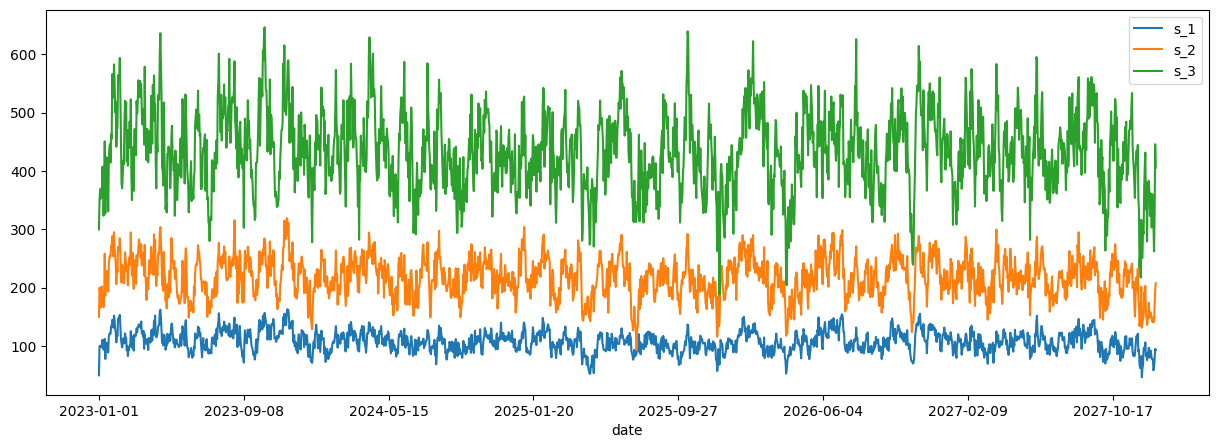

In [4]:
import pandas as pd

df = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df.set_index("date")[series].plot(figsize=(15, 5))
df.head()

df["date"] = pd.to_datetime(df["date"])


In [5]:


# melt the series and prepare for the model

df_demand = df.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df[["date", "holiday", "weather"]].drop_duplicates()

#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])




C:\Users\Matty\AppData\Local\Temp\ipykernel_39460\393126946.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


## Dataset

{'s_1': 2023-01-01     50.000000
2023-01-02    100.000000
2023-01-03    100.609331
2023-01-04     99.437613
2023-01-05     98.066940
                 ...    
2026-12-28    120.264230
2026-12-29    118.535174
2026-12-30    131.680382
2026-12-31    120.804782
2027-01-01    112.920027
Freq: D, Name: s_1, Length: 1462, dtype: float64, 's_2': 2023-01-01    150.000000
2023-01-02    200.000000
2023-01-03    195.258758
2023-01-04    165.805578
2023-01-05    176.120203
                 ...    
2026-12-28    205.607562
2026-12-29    195.561457
2026-12-30    231.420596
2026-12-31    222.497103
2027-01-01    197.598421
Freq: D, Name: s_2, Length: 1462, dtype: float64, 's_3': 2023-01-01    300.000000
2023-01-02    350.000000
2023-01-03    368.269784
2023-01-04    351.979250
2023-01-05    369.788392
                 ...    
2026-12-28    455.747469
2026-12-29    476.620917
2026-12-30    489.294530
2026-12-31    451.135654
2027-01-01    402.214478
Freq: D, Name: s_3, Length: 1462, dtype: float64}
{'s

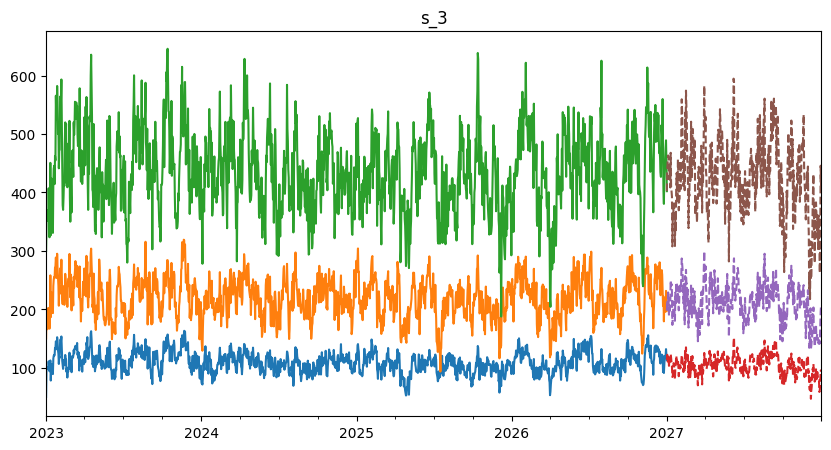

In [6]:
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold

# define split date
split_date = "2027-01-01"

mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)

dataset.show_sizes()
dataset.plot_series()


In [7]:


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [2,4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  



  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features: 5
[LightGBM] [Info] Start training from score 0.506060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

(            levels          lags  \
 0  [s_1, s_2, s_3]        [1, 2]   
 1  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 2  [s_1, s_2, s_3]  [1, 2, 3, 4]   
 3  [s_1, s_2, s_3]        [1, 2]   
 4  [s_1, s_2, s_3]        [1, 2]   
 5  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 6  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 7  [s_1, s_2, s_3]        [1, 2]   
 8  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 9  [s_1, s_2, s_3]  [1, 2, 4, 5]   
 
                                               params  \
 0  {'n_estimators': 912, 'max_depth': 4, 'learnin...   
 1  {'n_estimators': 1009, 'max_depth': 10, 'learn...   
 2  {'n_estimators': 643, 'max_depth': 7, 'learnin...   
 3  {'n_estimators': 706, 'max_depth': 12, 'learni...   
 4  {'n_estimators': 531, 'max_depth': 6, 'learnin...   
 5  {'n_estimators': 652, 'max_depth': 10, 'learni...   
 6  {'n_estimators': 375, 'max_depth': 8, 'learnin...   
 7  {'n_estimators': 351, 'max_depth': 6, 'learnin...   
 8  {'n_estimators': 850, 'max_depth': 14, 'learni...   
 9  {'n_estimators': 

c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:966: MissingValuesWarning: `exog` for series 's_1' doesn't have as many values as steps predicted, 365. Missing values are filled with NaN. Most of machine learning models do not allow missing values. Prediction method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:1036: MissingValuesWarning: To make predictions `exog` for series 's_1' must start one step ahead of `last_window`. Missing values are filled with NaN.
    `last_window` ends at : 2027-01-01 00:00:00.
    `exog` for series 's_1' starts at : 2027-01-01 00:00:00.
     Expected index       : 2027-01-02 00:00:00. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Matty\anaconda3\envs\featur

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5

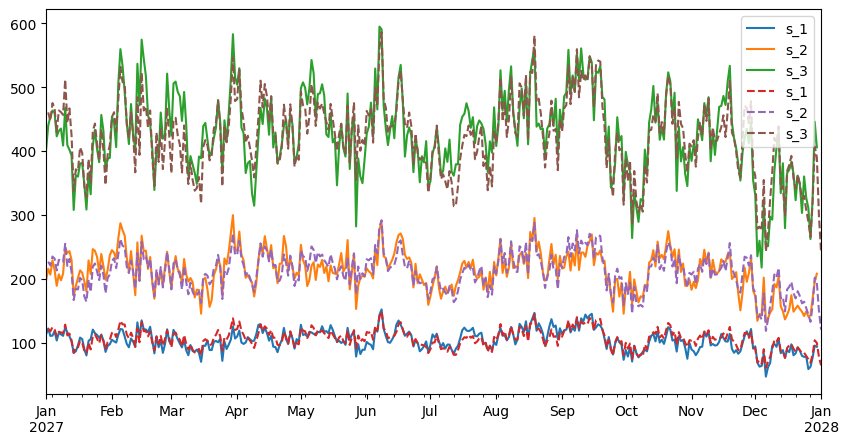

In [8]:
forecaster.plot_forecast()

In [9]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5


,PFI_MSE_TEST,SHAP_TEST
weather,0.016269,0.073452
lag_1,0.014321,0.070188
lag_2,0.001824,0.025234
holiday,0.000198,0.008827
_level_skforecast,0.000016,0.002184


Rank          
                  PFI_MSE_TEST SHAP_TEST
weather                      1         1
lag_1                        2         2
lag_2                        3         3
holiday                      4         4
_level_skforecast            5         5

Perc           
                  PFI_MSE_TEST  SHAP_TEST
weather              49.861723  40.832589
lag_1                43.891331  39.018312
lag_2                 5.591037  14.028030
holiday               0.606299   4.906745
_level_skforecast     0.049610   1.214324

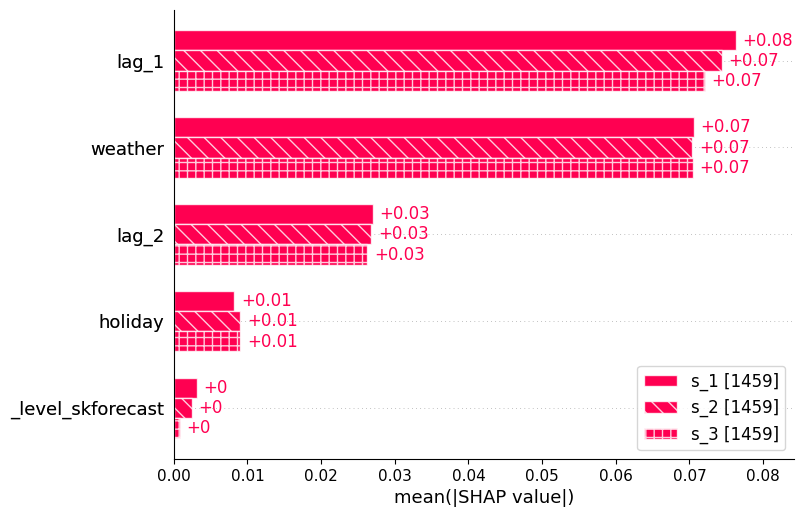

In [10]:
fi.plot_importance_for_series()

In [ ]:
def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [2,4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
    }


regressor = LGBMRegressor()

# scaler = MinMaxScaler()
scaler = None

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster = ForecasterMsExog( 
    data = dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)

forecaster.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

fi = ForecasterMsExogFeatureImportance(forecaster)


display(fi.feature_importance)
display(fi.feature_rank)
display(fi.relative_feature_importance)

fi.plot_importance_for_series()


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\utils\utils.py:561: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTypeWarning)
  warnings.warn(


[W 2024-12-10 17:23:56,591] Trial 0 failed with parameters: {'lags': 2, 'n_estimators': 706, 'max_depth': 12, 'learning_rate': 0.01, 'min_samples_leaf': 10} because of the following error: ValueError('pandas dtypes must be int, float or bool.\nFields with bad pandas dtypes: holiday: object').
Traceback (most recent call last):
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\model_selection\_search.py", line 1839, in _objective
    metrics, _ = backtesting_forecaster_multiseries(
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\model_selection\_validation.py", line 905, in backtesting_forecaster_multiseries
    metrics_levels, backtest_predictions = _backtesting_forecaster_multiseries(
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-pack

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: holiday: object